# Firing Response to Background Synaptic Stimulation

In [1]:
import numpy as np

from cell_template import Cell, BRANCH_COLORS
from parallel import Parallel

import sys
sys.path.append('../..')
import plot_tools as pt
import matplotlib.pylab as plt

# Perform numerical simulation

run:
```
# for the Basket Cell
python bgStim_to_firingFreq.py --cellType Basket --tstop 3000 --test_uniform
# for the Martinotti Cell
python bgStim_to_firingFreq.py --cellType Martinotti --tstop 3000 --test_NMDA
```

# Analyze and Plot Simulations

## Basket Cell

In [22]:
# load simulation data
sim = Parallel(\
        filename='../../data/detailed_model/Basket_bgStim_sim.zip')

sim.load()
sim.fetch_quantity_on_grid('Vm', dtype=object) 
sim.fetch_quantity_on_grid('output_rate', dtype=float) 
dt = sim.fetch_quantity_on_grid('dt', dtype=float, return_last=True)

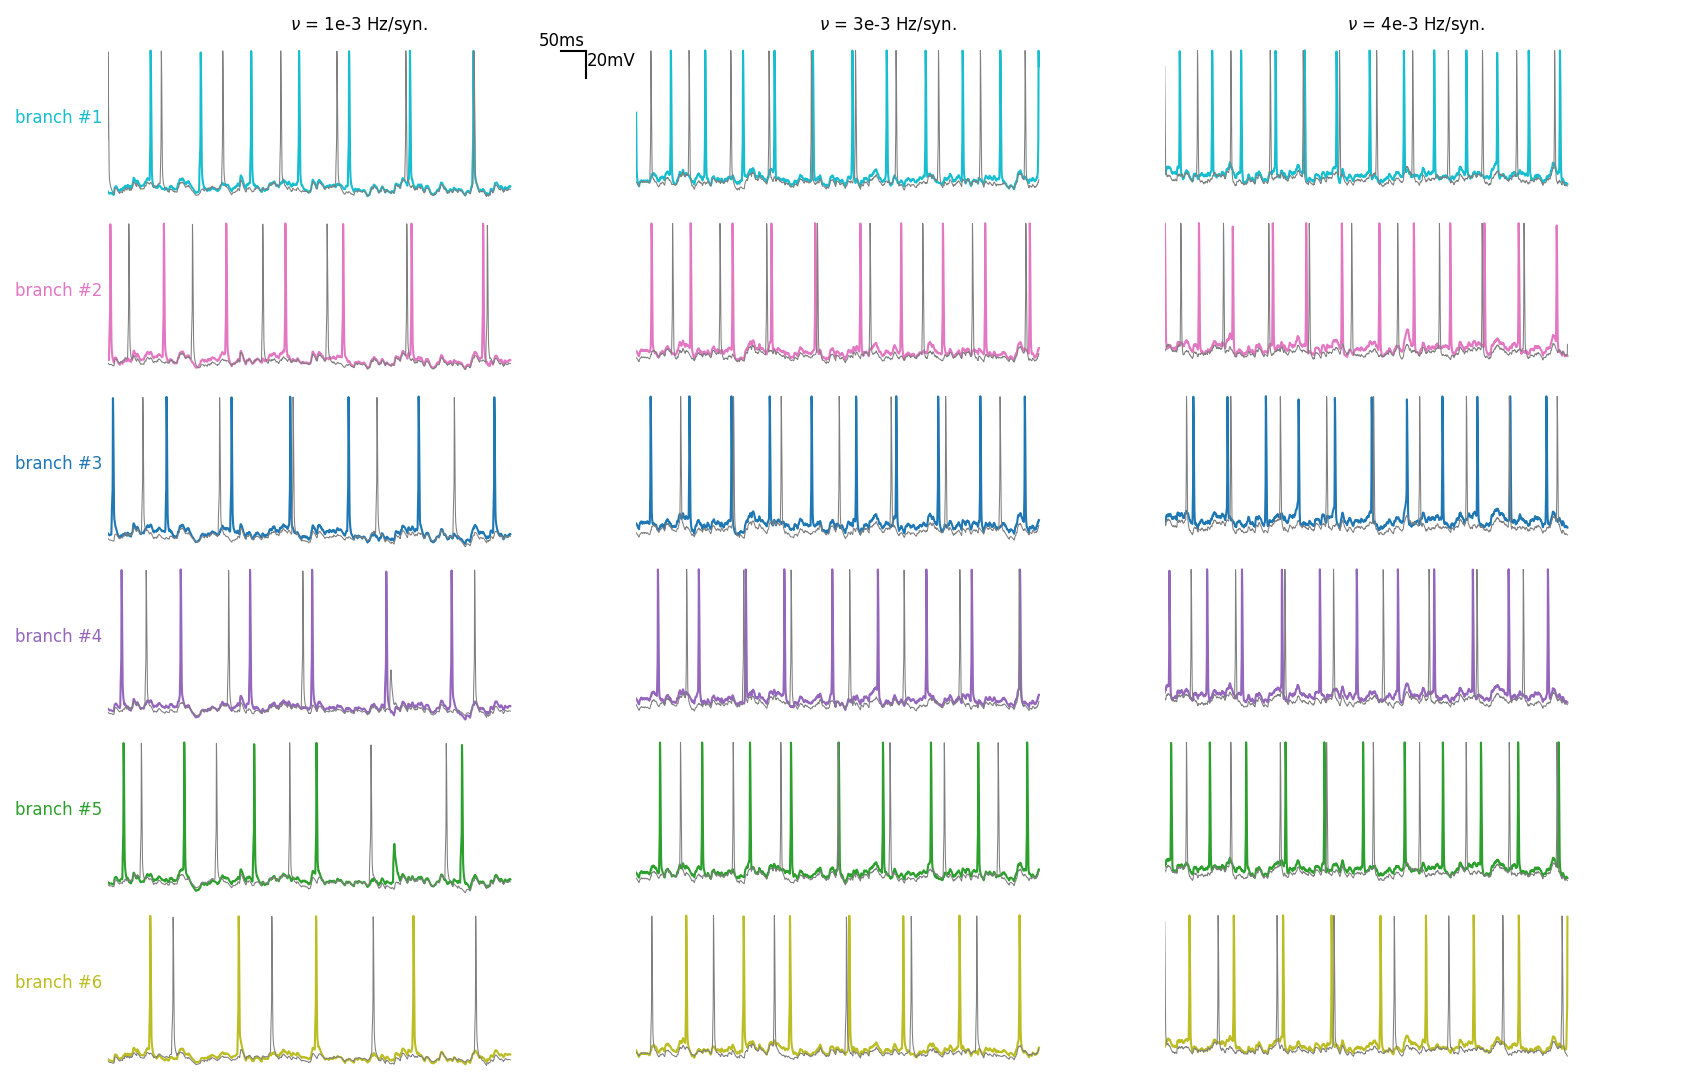

In [23]:
tZoom = [200,1200] # ms

N = 3 # max freq panels
fig, AX = pt.figure(axes=(N, len(np.unique(sim.iBranch))),
                    figsize=2*np.array((.9,0.6)), reshape_axes=False)
plt.subplots_adjust(wspace=0.05, hspace=0.02)

trial = 2

for iB, iBranch in enumerate(np.unique(sim.iBranch)):
    pt.annotate(AX[iB][0], 'branch #%i ' % (1+iBranch), (0,.5), ha='right', color=BRANCH_COLORS[iB])
    for iF, bgStimFreq in enumerate(np.unique(sim.bgStimFreq)[1:N+1]):
        if iB==0:
            AX[0][iF].set_title(str('$\\nu$ = %.0e Hz/syn.' % bgStimFreq).replace('-0', '-'))
        for from_uniform, color, lw in zip([False, True], [BRANCH_COLORS[iB], 'tab:grey'], [1, 0.5]):
            Vm = sim.get('Vm', dict(from_uniform=from_uniform,
                                    iBranch=iBranch,
                                    bgStimFreq=bgStimFreq))[0]
            AX[iB][iF].plot(np.arange(len(Vm))*dt, Vm, color=color, lw=lw)
            AX[iB][iF].axis('off')
            if tZoom is not None:
                AX[iB][iF].set_xlim(tZoom)
            
pt.set_common_ylims(AX)
pt.set_common_ylims(AX)
pt.draw_bar_scales(AX[0][0], loc='top-right',
                   Xbar=50, Xbar_label='50ms',
                   Ybar=20, Ybar_label='20mV')

fig.savefig('../../figures/detailed_model/bgStim-example-traces-BC.svg')

### Trace with dendritic $V_m$

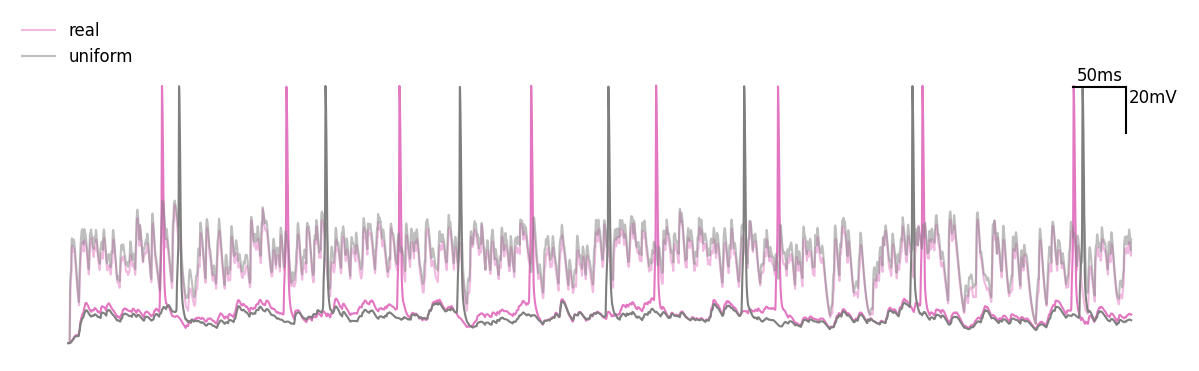

In [24]:
sim.fetch_quantity_on_grid('Vm_dend', dtype=object) # fetch dendritic Vm recording
                           
fig, ax = pt.figure(figsize=(3,3))

params = dict(iBranch = 1, bgStimFreq = np.unique(sim.bgStimFreq)[1])

for from_uniform, color, label in zip([False, True],
                                      [BRANCH_COLORS[params['iBranch']], 'tab:grey'], ['real', 'uniform']):
    Vm = sim.get('Vm', dict(from_uniform=from_uniform, **params))[0]
    ax.plot(np.arange(len(Vm))*dt, Vm, color=color, lw=1)
    Vm = sim.get('Vm_dend', dict(from_uniform=from_uniform, **params))[0]
    ax.plot(np.arange(len(Vm))*dt, Vm, color=color, lw=1, label=label, alpha=0.5)
ax.legend(frameon=False, loc=(0,1))
ax.axis('off')

pt.draw_bar_scales(ax, loc='top-right',
                   Xbar=50, Xbar_label='50ms',
                   Ybar=20, Ybar_label='20mV')

fig.savefig('../../figures/detailed_model/bgStim-example-trace-with-dendrite-BC.svg')

### Input-Output curves on all Branches

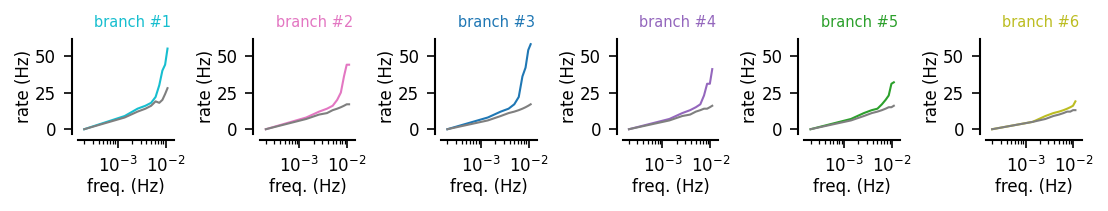

In [16]:
fig, AX = pt.figure(axes=(len(np.unique(sim.iBranch)), 1),
                    figsize=(0.9,1.0), reshape_axes=False)
plt.subplots_adjust(wspace=0.9)

for iB, iBranch in enumerate(np.unique(sim.iBranch)):
    c= BRANCH_COLORS[iB]
    AX[0][iB].set_title('   branch #%i' % (1+iBranch), fontsize=7, color=c)
    for from_uniform, color, lw in zip([False, True], [c, 'tab:grey'], [1, 0.5]):
        params = {'iBranch':iBranch, 'from_uniform':from_uniform}
        mX = [sim.get('output_rate', dict(**params, bgStimFreq=f)).mean() for f in np.unique(sim.bgStimFreq)]
        sX = [sim.get('output_rate', dict(**params, bgStimFreq=f)).std() for f in np.unique(sim.bgStimFreq)]
        pt.plot(np.unique(sim.bgStimFreq), mX, sy=sX, ax=AX[0][iB], color=color, ms=1)
    pt.set_plot(AX[0][iB], xlabel='freq. (Hz)', ylabel='rate (Hz)', xscale='log')
    
pt.set_common_ylims(AX)
pt.set_common_ylims(AX)

## Summary Input-Output curve for the Basket Cell

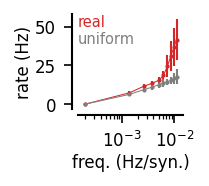

In [29]:
import numpy as np
import matplotlib.pylab as plt

import sys
sys.path.append('../..')
import plot_tools as pt

from parallel import Parallel
sim = Parallel(\
        filename='../../data/detailed_model/Basket_bgStim_sim.zip')

sim.load()
sim.fetch_quantity_on_grid('output_rate', dtype=float) 

fig, ax = pt.figure(figsize=(0.9,1.0))

Fin, Fout = np.unique(sim.bgStimFreq), {'real':[], 'uniform':[]}
for k, key, color in zip([0,1], ['real', 'uniform'], ['tab:red', 'tab:grey']):
    for iB, iBranch in enumerate(np.unique(sim.iBranch)):
        params = {'iBranch':iBranch, 'from_uniform':(key=='uniform')}
        Fout[key].append(\
            [sim.get('output_rate', dict(**params, bgStimFreq=f)).mean() for f in np.unique(sim.bgStimFreq)])
    pt.scatter(Fin, np.mean(Fout[key], axis=0), sy=np.std(Fout[key], axis=0), 
               color=color, ms=1, lw=0.5, ax=ax)
    pt.annotate(ax, k*'\n'+key, (0,1), va='top', color=color, fontsize=7)
pt.set_plot(ax, xlabel='freq. (Hz/syn.)', ylabel='rate (Hz)', xscale='log')

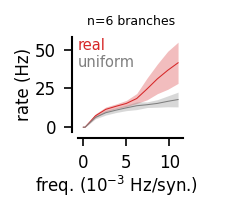

In [21]:
import numpy as np
import matplotlib.pylab as plt
#from scipy.stats import sem
import sys
sys.path.append('../..')
import plot_tools as pt

from parallel import Parallel
sim = Parallel(\
        filename='../../data/detailed_model/Basket_bgStim_sim.zip')

sim.load()
sim.fetch_quantity_on_grid('output_rate', dtype=float) 

fig, ax = pt.figure(figsize=(0.9,1.0))

nBranch = len(np.unique(sim.iBranch))
Fin, Fout = [0]+list(np.unique(sim.bgStimFreq)), {'real':[], 'uniform':[]}
for k, key, color in zip([0,1], ['real', 'uniform'], ['tab:red', 'tab:grey']):
    for iB, iBranch in enumerate(np.unique(sim.iBranch)):
        params = {'iBranch':iBranch, 'from_uniform':(key=='uniform')}
        Fout[key].append(\
            [0]+[sim.get('output_rate', dict(**params, bgStimFreq=f)).mean() for f in np.unique(sim.bgStimFreq)])
    pt.plot(1e3*np.array(Fin), np.mean(Fout[key], axis=0), sy=np.std(Fout[key], axis=0), 
               color=color, ms=1, lw=0.5, ax=ax)
    pt.annotate(ax, k*'\n'+key, (0,1), va='top', color=color, fontsize=7)
ax.set_title('n=%i branches' % (iBranch+1), color='k', fontsize=6)
pt.set_plot(ax, xlabel='freq. (10$^{-3}$ Hz/syn.)      ', ylabel='rate (Hz)')#, xscale='log')

# Martinotti Cell

In [37]:
# load simulation data
sim = Parallel(\
        filename='../../data/detailed_model/Martinotti_bgStim_sim.zip')

sim.load()
sim.fetch_quantity_on_grid('Vm', dtype=object) 
sim.fetch_quantity_on_grid('output_rate', dtype=float) 
dt = sim.fetch_quantity_on_grid('dt', dtype=float, return_last=True)

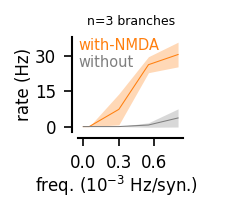

In [38]:
fig, ax = pt.figure(figsize=(0.9,1.0))

nBranch = len(np.unique(sim.iBranch))
Fin, Fout = [0]+list(np.unique(sim.bgStimFreq)), {'with-NMDA':[], 'without':[]}
for k, key, color in zip([0,1], ['with-NMDA', 'without'], ['tab:orange', 'tab:grey']):
    for iB, iBranch in enumerate(np.unique(sim.iBranch)):
        params = {'iBranch':iBranch, 'with_NMDA':(key=='with-NMDA')}
        Fout[key].append(\
            [0]+[sim.get('output_rate', dict(**params, bgStimFreq=f)).mean() for f in np.unique(sim.bgStimFreq)])
    pt.plot(1e3*np.array(Fin), np.mean(Fout[key], axis=0), sy=np.std(Fout[key], axis=0), 
               color=color, ms=1, lw=0.5, ax=ax)
    pt.annotate(ax, k*'\n'+key, (0,1), va='top', color=color, fontsize=7)
ax.set_title('n=%i branches' % (iBranch+1), color='k', fontsize=6)
pt.set_plot(ax, xlabel='freq. (10$^{-3}$ Hz/syn.)      ', ylabel='rate (Hz)')#, xscale='log')

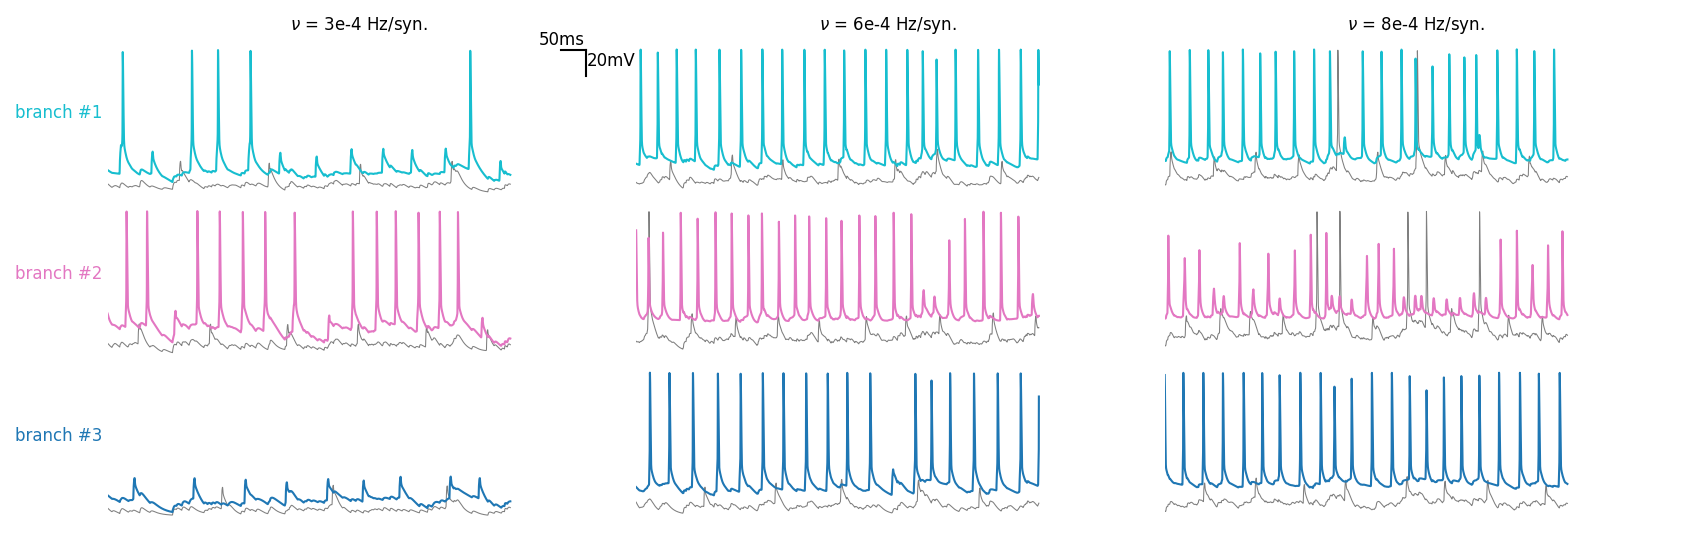

In [39]:
tZoom = [200,1200] # ms

N = 3 # max freq panels
fig, AX = pt.figure(axes=(N, len(np.unique(sim.iBranch))),
                    figsize=2*np.array((.9,0.6)), reshape_axes=False)
plt.subplots_adjust(wspace=0.05, hspace=0.02)

trial = 2

for iB, iBranch in enumerate(np.unique(sim.iBranch)):
    pt.annotate(AX[iB][0], 'branch #%i ' % (1+iBranch), (0,.5), ha='right', color=BRANCH_COLORS[iB])
    for iF, bgStimFreq in enumerate(np.unique(sim.bgStimFreq)[1:N+1]):
        if iB==0:
            AX[0][iF].set_title(str('$\\nu$ = %.0e Hz/syn.' % bgStimFreq).replace('-0', '-'))
        for with_NMDA, color, lw in zip([False, True], ['tab:grey', BRANCH_COLORS[iB]], [0.5, 1]):
            Vm = sim.get('Vm', dict(with_NMDA=with_NMDA,
                                    iBranch=iBranch,
                                    bgStimFreq=bgStimFreq))[0]
            AX[iB][iF].plot(np.arange(len(Vm))*dt, Vm, color=color, lw=lw)
            AX[iB][iF].axis('off')
            if tZoom is not None:
                AX[iB][iF].set_xlim(tZoom)
            
pt.set_common_ylims(AX)
pt.set_common_ylims(AX)
pt.draw_bar_scales(AX[0][0], loc='top-right',
                   Xbar=50, Xbar_label='50ms',
                   Ybar=20, Ybar_label='20mV')

fig.savefig('../../figures/detailed_model/bgStim-example-traces-BC.svg')

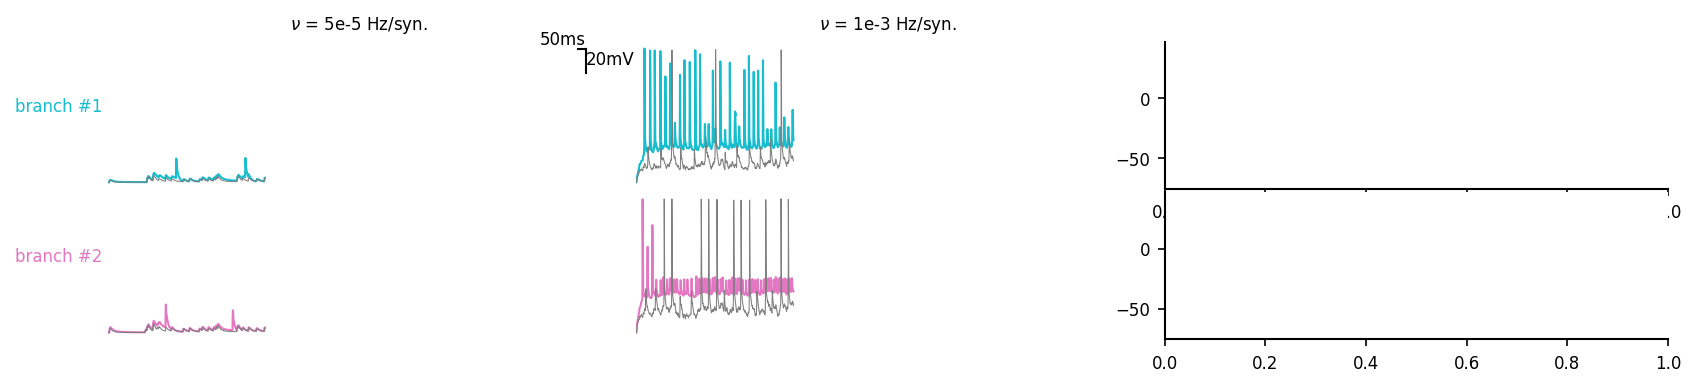

In [20]:
tZoom = [0,3200] # ms

sim.fetch_quantity_on_grid('Vm', dtype=object) 

N = 3 # max freq panels
fig, AX = pt.figure(axes=(N, len(np.unique(sim.iBranch))),
                    figsize=2*np.array((.9,0.6)), reshape_axes=False)
plt.subplots_adjust(wspace=0.05, hspace=0.02)

trial = 2

NAr = np.unique(sim.NMDAtoAMPA_ratio)[1]

for iB, iBranch in enumerate(np.unique(sim.iBranch)):
    pt.annotate(AX[iB][0], 'branch #%i ' % (1+iBranch), (0,.5), ha='right', color=BRANCH_COLORS[iB])
    for iF, bgStimFreq in enumerate(np.unique(sim.bgStimFreq)[:N]):
        if iB==0:
            AX[0][iF].set_title(str('$\\nu$ = %.0e Hz/syn.' % bgStimFreq).replace('-0', '-'))
        for nar, color, lw in zip([NAr, 0.], [BRANCH_COLORS[iB], 'tab:grey'], [1, 0.5]):
            Vm = sim.get('Vm', dict(NMDAtoAMPA_ratio=nar,
                                    iBranch=iBranch,
                                    bgStimFreq=bgStimFreq))[0]
            AX[iB][iF].plot(np.arange(len(Vm))*dt, Vm, color=color, lw=lw)
            AX[iB][iF].axis('off')
            if tZoom is not None:
                AX[iB][iF].set_xlim(tZoom)
            
pt.set_common_ylims(AX)
pt.set_common_ylims(AX)
pt.draw_bar_scales(AX[0][0], loc='top-right',
                   Xbar=50, Xbar_label='50ms',
                   Ybar=20, Ybar_label='20mV')

#fig.savefig('../../figures/detailed_model/bgStim-example-traces-MC.svg')

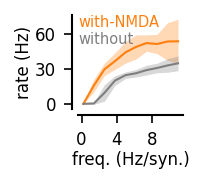

In [31]:
sim = Parallel(\
        filename='../../data/detailed_model/Martinotti_bgStim_sim.zip')

sim.load()
sim.fetch_quantity_on_grid('output_rate', dtype=float) 

fig, ax = pt.figure(figsize=(0.9,1.0))

Fin, Fout = np.unique(sim.bgStimFreq), {'with-NMDA':[], 'without':[]}
for k, key, color in zip([0,1], ['with-NMDA', 'without'], ['tab:orange', 'tab:grey']):
    for iB, iBranch in enumerate(np.unique(sim.iBranch)):
        params = {'iBranch':iBranch, 'NMDAtoAMPA_ratio':2. if (key=='with-NMDA') else 0.}
        Fout[key].append(\
            [sim.get('output_rate', dict(**params, bgStimFreq=f)).mean() for f in np.unique(sim.bgStimFreq)])
    pt.plot(1e3*Fin, np.mean(Fout[key], axis=0), sy=np.std(Fout[key], axis=0), 
               color=color, ax=ax)
    pt.annotate(ax, k*'\n'+key, (0,1), va='top', color=color, fontsize=7)
pt.set_plot(ax, xlabel='freq. (Hz/syn.)', ylabel='rate (Hz)')#, xscale='log')

### Checking the real vs uniform distribution for the Martinotti as well

Run sim:
```
python bgStim_to_firing_Freq.py -c Martinotti --Fmin 2e-4 --Fmax 1e-4 --nF 4
```

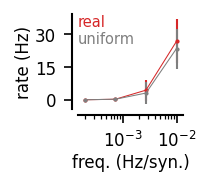

In [37]:
import numpy as np
import matplotlib.pylab as plt

import sys
sys.path.append('../..')
import plot_tools as pt

from parallel import Parallel
sim = Parallel(\
        filename='../../data/detailed_model/Martinotti_bgStim_sim_real_vs_uniform.zip')

sim.load()
sim.fetch_quantity_on_grid('output_rate', dtype=float) 

fig, ax = pt.figure(figsize=(0.9,1.0))

Fin, Fout = np.unique(sim.bgStimFreq), {'real':[], 'uniform':[]}
for k, key, color in zip([0,1], ['real', 'uniform'], ['tab:red', 'tab:grey']):
    for iB, iBranch in enumerate(np.unique(sim.iBranch)):
        params = {'iBranch':iBranch, 'from_uniform':(key=='uniform')}
        Fout[key].append(\
            [sim.get('output_rate', dict(**params, bgStimFreq=f)).mean() for f in np.unique(sim.bgStimFreq)])
    pt.scatter(Fin, np.mean(Fout[key], axis=0), sy=np.std(Fout[key], axis=0), 
               color=color, ms=1, lw=0.5, ax=ax)
    pt.annotate(ax, k*'\n'+key, (0,1), va='top', color=color, fontsize=7)
pt.set_plot(ax, xlabel='freq. (Hz/syn.)', ylabel='rate (Hz)', xscale='log')